In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from PIL.ExifTags import TAGS
from dotenv import load_dotenv
import matplotlib.pyplot as plt

In [2]:
chexpert_root = "path/to/chexpert_root"
train_data_dirname = "train_data"
raw_train_data_info_filename = "train.csv"
data_stats_dirname = "data_stats"

In [3]:
raw_train_data_info = pd.read_csv(os.path.join(chexpert_root, raw_train_data_info_filename))

In [4]:
raw_train_data_info['Path'] = raw_train_data_info['Path'].str.replace('CheXpert-v1.0/train/', '')

raw_train_data_info = raw_train_data_info.loc[:, 'Path':'AP/PA']

raw_train_data_info['Frontal(AP/PA)/Lateral'] = raw_train_data_info['Frontal/Lateral'].str.cat(raw_train_data_info['AP/PA'].fillna(''), sep='')

raw_train_data_info = raw_train_data_info.drop(columns=['Frontal/Lateral', 'AP/PA'])


In [5]:
train_ims_widths_path = os.path.join(chexpert_root, data_stats_dirname, "train_ims_widths.npy")
train_ims_heights_path = os.path.join(chexpert_root, data_stats_dirname, "train_ims_heights.npy")
train_ims_min_pixvals_path = os.path.join(chexpert_root, data_stats_dirname, "train_ims_min_pixvals.npy")
train_ims_max_pixvals_path = os.path.join(chexpert_root, data_stats_dirname, "train_ims_max_pixvals.npy")
train_ims_modes_path = os.path.join(chexpert_root, data_stats_dirname, "train_ims_modes.npy")
if os.path.exists(train_ims_widths_path) and os.path.exists(train_ims_heights_path) and os.path.exists(train_ims_min_pixvals_path) and os.path.exists(train_ims_max_pixvals_path) and os.path.exists(train_ims_modes_path):
    train_ims_widths = np.load(train_ims_widths_path)
    train_ims_heights = np.load(train_ims_heights_path)
    train_ims_min_pixvals = np.load(train_ims_min_pixvals_path)
    train_ims_max_pixvals = np.load(train_ims_max_pixvals_path)
    train_ims_modes = np.load(train_ims_modes_path)
else:
    train_ims_widths = []
    train_ims_heights = []
    train_ims_min_pixvals = []
    train_ims_max_pixvals = []
    train_ims_modes = []

    for index, row in raw_train_data_info.iterrows():
        image = Image.open(os.path.join(chexpert_root, train_data_dirname, raw_train_data_info.loc[index]["Path"]))

        train_ims_modes.append(image.mode)

        image_width, image_height = image.size
        train_ims_widths.append(image_width)
        train_ims_heights.append(image_height)

        min_pixval, max_pixval = image.getextrema()
        train_ims_min_pixvals.append(min_pixval)
        train_ims_max_pixvals.append(max_pixval)
    train_ims_widths = np.array(train_ims_widths)
    train_ims_heights = np.array(train_ims_heights)
    train_ims_min_pixvals = np.array(train_ims_min_pixvals)
    train_ims_max_pixvals = np.array(train_ims_max_pixvals)
    train_ims_modes = np.array(train_ims_modes)

    np.save(train_ims_widths_path, train_ims_widths)
    np.save(train_ims_heights_path, train_ims_heights)
    np.save(train_ims_min_pixvals_path, train_ims_min_pixvals)
    np.save(train_ims_max_pixvals_path, train_ims_max_pixvals)
    np.save(train_ims_modes_path, train_ims_modes)


In [6]:
print("Minium image width:", train_ims_widths.min())
print("Maximum image width:", train_ims_widths.max())

print("Minium image height:", train_ims_heights.min())
print("Maximum image height:", train_ims_heights.max())

Minium image width: 833
Maximum image width: 4248
Minium image height: 695
Maximum image height: 4248


In [7]:
def plot_hist(x: np.ndarray, title: str, bins:int = 30):
    plt.hist(x, bins = bins)
    plt.title(label = title)
    plt.show()

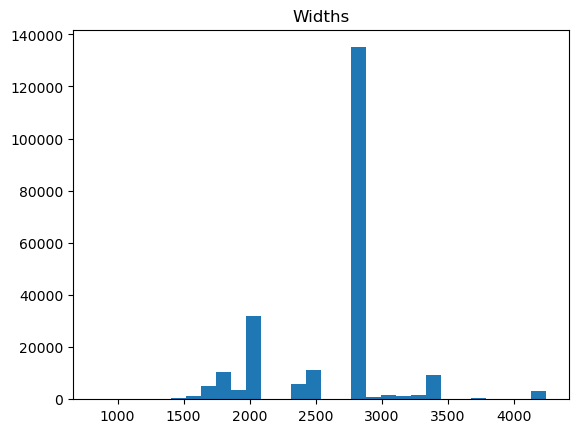

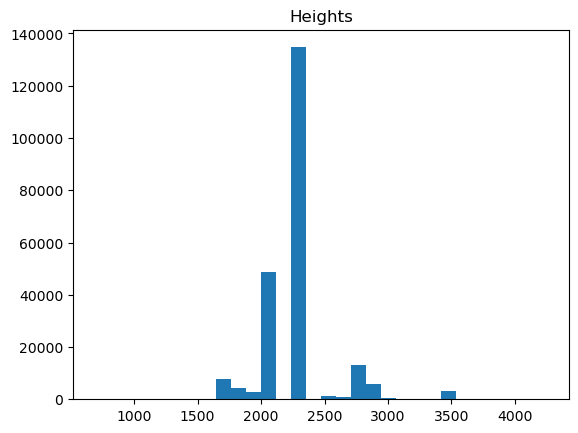

In [8]:
plot_hist(train_ims_widths, title = "Widths")
plot_hist(train_ims_heights, title = "Heights")

In [9]:
aspect_ratios = train_ims_widths / train_ims_heights
print("Maximum aspect ratio:", aspect_ratios.max())
print("Minimum aspect ratio:", aspect_ratios.min())

Maximum aspect ratio: 2.9079136690647482
Minimum aspect ratio: 0.49777337951509154


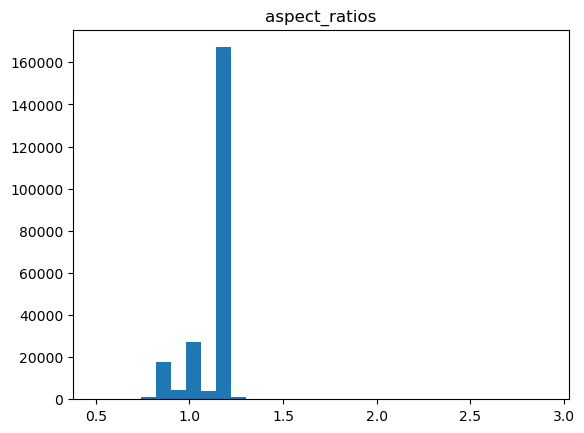

In [10]:
plot_hist(aspect_ratios, title = "aspect_ratios")

In [11]:
aspect_ratios_mask_path = os.path.join(chexpert_root, data_stats_dirname, "train_aspect_ratios_mask.npy")
if os.path.exists(aspect_ratios_mask_path):
    aspect_ratios_mask = np.load(aspect_ratios_mask_path)
else:
    aspect_ratios_mask = (aspect_ratios > 1.3) | (aspect_ratios < 0.7)
    np.save(os.path.join(chexpert_root, data_stats_dirname, "train_aspect_ratios_mask.npy"), aspect_ratios_mask)

In [12]:
print("Unique minimal pixel values:", np.unique(train_ims_min_pixvals))
print("Unique maximal pixel values:", np.unique(train_ims_max_pixvals))
print("Unique image modes:", np.unique(train_ims_modes))

Unique minimal pixel values: [0]
Unique maximal pixel values: [255]
Unique image modes: ['L']


In [13]:
print(aspect_ratios_mask)

[False False False ... False False False]


In [14]:
filtered_train_data_info = raw_train_data_info[~aspect_ratios_mask]

In [15]:
print(filtered_train_data_info["Frontal(AP/PA)/Lateral"].value_counts())

Frontal(AP/PA)/Lateral
FrontalAP    161190
Lateral       32318
FrontalPA     29391
FrontalLL        16
FrontalRL         1
Name: count, dtype: int64


In [16]:
df_frontal_ap = filtered_train_data_info[filtered_train_data_info["Frontal(AP/PA)/Lateral"] == "FrontalAP"]
df_frontal_pa = filtered_train_data_info[filtered_train_data_info["Frontal(AP/PA)/Lateral"] == "FrontalPA"]
df_lateral = filtered_train_data_info[filtered_train_data_info["Frontal(AP/PA)/Lateral"] == "Lateral"]

In [17]:
test_frontal_ap = df_frontal_ap.sample(n=8000, replace=False, random_state=42)
df_frontal_ap = df_frontal_ap.drop(test_frontal_ap.index)

test_frontal_pa = df_frontal_pa.sample(n=8000, replace=False, random_state=42)
df_frontal_pa = df_frontal_pa.drop(test_frontal_pa.index)

test_lateral = df_lateral.sample(n=8000, replace=False, random_state=42)
df_lateral = df_lateral.drop(test_lateral.index)


In [18]:
test_data_info = pd.concat([test_frontal_ap, test_frontal_pa, test_lateral])
test_data_info = test_data_info.sample(frac=1, random_state=42).reset_index(drop=True)
print(test_data_info)

test_data_info.to_csv(os.path.join(chexpert_root, "test_data_info.csv"), index=False)

                                         Path     Sex  Age  \
0       patient10570/study2/view1_frontal.jpg    Male   82   
1      patient03070/study11/view3_lateral.jpg    Male   74   
2       patient18526/study5/view2_lateral.jpg    Male   61   
3      patient19317/study36/view2_lateral.jpg    Male   42   
4       patient30903/study1/view3_lateral.jpg    Male   86   
...                                       ...     ...  ...   
23995  patient34413/study12/view2_lateral.jpg    Male   40   
23996   patient42302/study7/view1_frontal.jpg    Male   64   
23997   patient12836/study3/view1_frontal.jpg    Male   72   
23998   patient01946/study1/view1_frontal.jpg    Male   52   
23999   patient07969/study2/view2_lateral.jpg  Female   45   

      Frontal(AP/PA)/Lateral  
0                  FrontalAP  
1                    Lateral  
2                    Lateral  
3                    Lateral  
4                    Lateral  
...                      ...  
23995                Lateral  
23996  

In [19]:
valid_frontal_ap = df_frontal_ap.sample(n = 800, replace = False, random_state=42)
df_frontal_ap = df_frontal_ap.drop(valid_frontal_ap.index)


valid_frontal_pa = df_frontal_pa.sample(n = 800, replace = False, random_state=42)
df_frontal_pa = df_frontal_pa.drop(valid_frontal_pa.index)


valid_lateral = df_lateral.sample(n = 800, replace = False, random_state=42)
df_lateral = df_lateral.drop(valid_lateral.index)

In [20]:
final_valid_data_info = pd.concat([valid_frontal_ap, valid_frontal_pa, valid_lateral])
final_valid_data_info = final_valid_data_info.sample(frac=1, random_state=42).reset_index(drop=True)
print(final_valid_data_info)

final_valid_data_info.to_csv(os.path.join(chexpert_root, "valid_data_info.csv"), index=False)

                                       Path     Sex  Age  \
0     patient32528/study1/view2_lateral.jpg  Female   81   
1     patient26861/study8/view2_lateral.jpg    Male   68   
2     patient03551/study1/view1_frontal.jpg  Female   35   
3     patient12832/study3/view2_lateral.jpg    Male   66   
4     patient18710/study2/view2_lateral.jpg    Male   56   
...                                     ...     ...  ...   
2395  patient15184/study1/view2_lateral.jpg    Male   69   
2396  patient10261/study2/view1_frontal.jpg  Female   77   
2397  patient28831/study1/view1_frontal.jpg    Male   63   
2398  patient07718/study1/view1_frontal.jpg  Female   90   
2399  patient22207/study1/view1_frontal.jpg    Male   27   

     Frontal(AP/PA)/Lateral  
0                   Lateral  
1                   Lateral  
2                 FrontalPA  
3                   Lateral  
4                   Lateral  
...                     ...  
2395                Lateral  
2396              FrontalPA  
2397     

In [21]:
train_frontal_ap = df_frontal_ap.sample(n = 152390, replace = False, random_state=42)
df_frontal_ap = df_frontal_ap.drop(train_frontal_ap.index)

train_frontal_pa = df_frontal_pa.sample(n = 20591, replace = False, random_state=42)
df_frontal_pa = df_frontal_pa.drop(train_frontal_pa.index)

train_lateral = df_lateral.sample(n = 23518, replace = False, random_state=42)
df_lateral = df_lateral.drop(train_lateral.index)

In [22]:
train_data_info = pd.concat([train_frontal_ap, train_frontal_pa, train_lateral])
train_data_info = train_data_info.sample(frac=1, random_state=42).reset_index(drop=True)
print(train_data_info)

train_data_info.to_csv(os.path.join(chexpert_root, "train_data_info.csv"), index=False)

                                          Path     Sex  Age  \
0        patient00898/study1/view2_lateral.jpg  Female   56   
1        patient26545/study1/view1_frontal.jpg  Female   86   
2        patient12280/study5/view1_frontal.jpg  Female   61   
3        patient07498/study1/view2_lateral.jpg  Female   21   
4        patient44437/study8/view1_frontal.jpg    Male   90   
...                                        ...     ...  ...   
196494   patient39481/study3/view1_frontal.jpg  Female   40   
196495  patient10907/study26/view1_frontal.jpg    Male   37   
196496   patient13167/study1/view1_frontal.jpg    Male   57   
196497  patient15318/study15/view1_frontal.jpg    Male   25   
196498   patient40573/study1/view1_frontal.jpg    Male   72   

       Frontal(AP/PA)/Lateral  
0                     Lateral  
1                   FrontalAP  
2                   FrontalAP  
3                     Lateral  
4                   FrontalAP  
...                       ...  
196494             